In [1]:
# import necessary files
import os
import tensorflow as tf
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

#load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [2]:
def tensor_to_image(tensor):
    """Converts tensors to PIL image format

    Args:
        tensor (tf.Tensor): tensor object

    Returns: PIL.Image.fromarray

    """

    # resize image to 255
    tensor = tensor*255

    # convert tensor to numpy array for easy manipulation
    array_tensor = np.array(tensor, dtype=np.uint8)

    # 3-D: [height, width, channels]
    # 4-D: [batch, height, width, channels]
    if np.ndim(array_tensor) > 3: # if the tensor has more than 3 dimensions,
        assert array_tensor.shape[0] == 1 # ensure it has only 1 batch
        array_tensor = array_tensor[0] # and replace with the batch.

    return PIL.Image.fromarray(array_tensor) # return image converted from tensor

In [3]:
# test image
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
# test styling image
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [4]:
def load_image(path_to_image):
    """Define a function to load an image and limit its maximum dimension to 512 pixels

    Args:
        path_to_image (str): A filename (string), pathlib.Path object or a file object.

    Returns:
        tf.Tensor: If images was 4-D, a 4-D float Tensor of shape [batch, new_height, new_width, channels]. If images was 3-D, a 3-D float Tensor of shape [new_height, new_width, channels]

    """

    max_dim = 512
    img = tf.io.read_file(path_to_image)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32) # cast image height abd width shape as float
    long_dim = max(shape) # store max dim of shape (one of height or width)
    scale = max_dim / long_dim # get stated scale of maximum dimension to the dimension of the image

    new_shape = tf.cast(shape * scale, tf.int32) # scale up the image dimensions with 'scale'

    img = tf.image.resize(img, new_shape) # resize image with new image shape
    img = img[tf.newaxis, :] # expanding dimension by dding a new axis at the beginning of the tensor

    return img

In [5]:
def show_image(image, title=None):
    """Function to output an image data using matplotlib pyplot library.

    Args:
        None

    Returns:
        None
    """

    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0) # remove size 1 dimensions fromm the image shape

    plt.imshow(image)
    if title: # if a title is specified,
        plt.title(title) # show a title

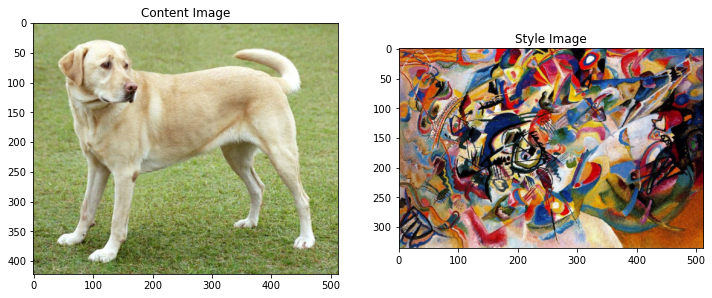

In [6]:
# load images
content_image = load_image(path_to_image=content_path)
style_image = load_image(path_to_image=style_path)

# show images
plt.subplot(1, 2, 1)
show_image(content_image, 'Content Image')
plt.subplot(1, 2, 2)
show_image(style_image, "Style Image")

In [7]:
'''
## Trying out tensorflow's original style-transfer algorithm
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)
'''

"\n## Trying out tensorflow's original style-transfer algorithm\nimport tensorflow_hub as hub\nhub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')\nstylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]\ntensor_to_image(stylized_image)\n"

In [8]:
input = tf.keras.applications.vgg19.preprocess_input(content_image*255)
input = tf.image.resize(input, (224, 224)) # VGG model requires input of 224 pixels
vgg_model = tf.keras.applications.VGG19(include_top=True, weights='imagenet') # '.\models\\vgg_model'
prediction_probabilities = vgg_model(input) # get prediction probabilities for content_image
prediction_probabilities.shape

574726144/574710816 [==============================] - 331s 1us/step


TensorShape([1, 1000])

In [14]:
vgg_model.save('.\models\\vgg_model_no_head')

INFO:tensorflow:Assets written to: .\models\vgg_model_no_head\assets


In [11]:
# trying out the model to ensure it's used properly
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

49152/35363 [=========================================] - 0s 3us/step


[('Labrador_retriever', 0.493171),
 ('golden_retriever', 0.2366529),
 ('kuvasz', 0.036357544),
 ('Chesapeake_Bay_retriever', 0.024182765),
 ('Greater_Swiss_Mountain_dog', 0.0186461)]

In [13]:
# load VGG19 model with no classification head
vgg_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

# list the layer names
print()
for layer in vgg_model.layers:
    print(layer.name)

80150528/80134624 [==============================] - 94s 1us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
'''
The goal is to try to match the intermediate layers of the model with
the style and content of the input image.

A CNN image classification model is chosen because it's built as a complex feature
extractor before leading to an out classification label. This will be ideal for
describing content and style of input images for this use case.

The first few layers (e.g. conv1) represent low-level features like edges and
textures while the final few layers (e.g. conv2) represent higher-level features
like object parts( wheels, eyes...)
'''

content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

# number of content layers
num_content_layers = len(content_layers)
# number of style layers
num_style_layers = len(style_layers)

In [ ]:
def vgg_intermediate_layers(layer_names):
    """Returns the list of intermediate layer output values

    Args:
        layer_names (list): A filename (string), pathlib.Path object or a file object.

    Returns:
        tf.Tensor: If images was 4-D, a 4-D float Tensor of shape [batch, new_height, new_width, channels]. If images was 3-D, a 3-D float Tensor of shape [new_height, new_width, channels]

    """